In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
run_training=True

In [9]:
def no_activation(a,derivate=False):
    if derivate:
        return np.ones(np.shape(a))
    return a

def sigmoid(a,derivate=False):
    if derivate:
        return a*(1-a)
    b=np.exp(-a)
    return(1/(1+b))

def relu(a,derivate=False):
    b = (a>0)*1
    if derivate: 
        return b
    return a*b

def return_max(a):
    a = np.argmax(a, axis=1)
    b = np.zeros((a.size, 3))
    b[np.arange(a.size),a] = 1
    return b

In [10]:
class layer:
    def __init__(self,input_size,output_size,bias=True,activation=no_activation):
        self.activation = activation
        self.bias = bias
        if bias:
            input_size+=1
        self.W = np.random.normal(0,1,(output_size,input_size))
        self.dW = np.zeros((output_size,input_size))
    
    def forward(self,x):
        if self.bias == True:
            x =  np.concatenate((x,np.ones((len(x),1))),axis=-1)
        self.z = x
        return self.activation(np.dot(x,np.transpose(self.W)))
    
    def backward(self,dy,y):
        d = dy*self.activation(y,derivate=True)
        dz = np.dot(d,self.W)
        self.dW += np.dot(np.transpose(d),self.z)
        if self.bias:
            return dz[:,:-1],self.z[:,:-1]
        return dz,self.z
    
    def update_weights(self,lr):
        self.W -= lr*self.dW
        self.dW = np.zeros(np.shape(self.W))

In [11]:
class polynomial_layer:
    def __init__(self,input_size,output_size,order=2,bias=True,activation=no_activation):
        self.activation = activation
        self.bias = bias
        self.order = order
        C = input_size*self.order
        if bias:
            C+=1
        self.W = np.random.normal(0,1,(output_size,C))
        self.dW = np.zeros((output_size,C))
    
    def forward(self,x):
        if self.order>1:
            x = np.concatenate([x**(i+1) for i in range(self.order)],axis=-1)
        if self.bias == True:
            x =  np.concatenate((x,np.ones((len(x),1))),axis=-1)
        self.z = x
        return self.activation(np.dot(x,np.transpose(self.W)))
    
    def backward(self,dy,y):
        ################################
        #### TÄSSÄ VÄLISSÄ ON VIRHE ####
        ################################
        d = dy*self.activation(y,derivate=True)
        dz = np.dot(d,self.W)
        ################################
        #### d/dz = a+2bx+3cx^2 ... ####
        ################################
        self.dW += np.dot(np.transpose(d),self.z)
        if self.bias:
            return dz[:,:-1],self.z[:,:-1]
        return dz,self.z
    
    def update_weights(self,lr):
        self.W -= lr*self.dW
        self.dW = np.zeros(np.shape(self.W))

In [12]:
class NN():
    def __init__(self):
        self.layers=[]
        self.N_layers = 0
    
    def forward(self,x):
        for n in range(self.N_layers):
            x = self.layers[n].forward(x)
        return x
    
    def backward(self,e,y):
        dy=-2*e
        for n in range(self.N_layers):
            dy,y = self.layers[-(n+1)].backward(dy,y)
            
    def update_weights(self,lr):
        for n in range(self.N_layers):
            self.layers[n].update_weights(lr)
        
    def add_layer(self,input_size,output_size,activation=no_activation,bias=True):
        try:
            new_layer = layer(input_size, output_size, activation=activation,bias=bias)
            self.layers.append(new_layer)
            self.N_layers+=1
        except:
            print("FAILURE")
    
    def add_polynomial_layer(self,input_size,output_size,activation=no_activation,bias=True):
        try:
            new_layer = polynomial_layer(input_size, output_size, activation=activation,bias=bias)
            self.layers.append(new_layer)
            self.N_layers+=1
        except:
            print("FAILURE")

In [13]:
def generate_data(dims,N,mu,sigma):
    x = np.random.multivariate_normal(np.ones(dims)*mu,np.eye(dims)*sigma,N)
    return x

def prepare_data(M,N,sigma=1,ordered=False):
    x1 = generate_data(M,N,-1,sigma)
    x2 = generate_data(M,N,1,sigma)
    x = np.concatenate((x1,x2))
    y = np.expand_dims(np.concatenate((np.zeros(N),np.ones(N))),axis=1)
    if ordered:
        return x,y
    keys = np.random.permutation(N*2)
    x=x[keys]
    y=y[keys]
    return x,y


def make_bit(x,b=8):
    x_bit = np.zeros((b,len(x)))
    for i in range(8):
        b = (x/2**i)%2
        x_bit[i]=b
        x=x-b*(2**i)
    return np.transpose(x_bit)
    

def get_prime_data(x):
    primes = np.array([2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,
                       67,71,73,79,83,89,97,101,103,107,109,113,127,131,
                       137,139,149,151,157,163,167,173,179,181,191,193,197,
                       199,211,223,227,229,233,239,241,251])
    return np.array([xi in primes for xi in x])*1

def prepare_prime_data(bs=None):
    x = np.array( [i for i in range(2,256)] )
    x_bit = make_bit(x)
    y = get_prime_data(x)
    if bs == None:
        return x_bit, np.expand_dims(y,axis=1)
    keys = np.random.permutation(256-2)
    y=np.expand_dims(y[keys],axis=1)
    r = np.random.randint(256-bs-3)
    return x_bit[r:r+bs],y[r:r+bs]

def prepare_complex_data(bs,function):
    x = np.random.randint(0,255,bs)
    x_bit = make_bit(x)
    y = np.expand_dims(function(x),axis=1)
    x = np.expand_dims(x,axis=1)
    return x,x_bit,y



## Test 1 y = x^2


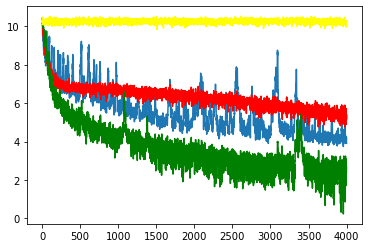

In [14]:
input_size = 8
output_size = 1
hidden_size = 200
    
batch_size = 50
epochs = 4000

#Learning for x**2
learning_rate = 10**-8/100

#Learning for sqrt()
#learning_rate = 2.5*10**-5
#learning_rate = 10**-6

    
Net1 = NN()
Net1.add_layer(input_size, hidden_size,activation=relu)
Net1.add_layer(hidden_size, hidden_size,activation=relu)
Net1.add_layer(hidden_size, output_size, activation=relu)
errors1 = np.zeros(epochs)

Net2 = NN()
Net2.add_layer(input_size, hidden_size,activation=relu)
Net2.add_layer(hidden_size, output_size, activation=relu)
errors2 = np.zeros(epochs)

Net3 = NN()
Net3.add_layer(input_size, hidden_size,activation=relu)
Net3.add_layer(hidden_size, hidden_size,activation=sigmoid)
Net3.add_layer(hidden_size, hidden_size,activation=relu)
Net3.add_layer(hidden_size, output_size, activation=relu)
errors3 = np.zeros(epochs)

Net4 = NN()
Net4.add_layer(input_size, hidden_size,activation=relu)
Net4.add_layer(hidden_size, hidden_size,activation=sigmoid)
Net4.add_layer(hidden_size, hidden_size,activation=relu)
Net4.add_layer(hidden_size, hidden_size,activation=relu)
Net4.add_layer(hidden_size, output_size, activation=relu)
errors4 = np.zeros(epochs)

for i in range(epochs):
    # Generate inputs
    x,x_bit,y=prepare_complex_data(batch_size,lambda x:x**2)
    # Forward
    y_hat_1 = Net1.forward(x_bit)
    y_hat_2 = Net2.forward(x_bit)
    y_hat_3 = Net3.forward(x_bit)
    y_hat_4 = Net4.forward(x_bit)
    #Error
    e1 = (y-y_hat_1)
    e2 = (y-y_hat_2)
    e3 = (y-y_hat_3)
    e4 = (y-y_hat_4)
    errors1[i] = np.sqrt(np.sum(e1**2)/batch_size)
    errors2[i] = np.sqrt(np.sum(e2**2)/batch_size)
    errors3[i] = np.sqrt(np.sum(e3**2)/batch_size)
    errors4[i] = np.sqrt(np.sum(e4**2)/batch_size)
    #backward
    Net1.backward(e1, y_hat_1)
    Net2.backward(e2, y_hat_2)
    Net3.backward(e3, y_hat_3)
    Net4.backward(e4, y_hat_4)
    Net1.update_weights(learning_rate*50)
    Net2.update_weights(learning_rate*1000)
    Net3.update_weights(learning_rate*50)
    Net4.update_weights(learning_rate*3)

plt.plot(np.log(errors1))
plt.plot(np.log(errors2),color='red')
plt.plot(np.log(errors3),color='green')
plt.plot(np.log(errors4),color='yellow')
plt.show()

In [16]:
x,x_bit,y=prepare_complex_data(10,lambda x:x**2)
y_hat_1 = Net1.forward(x_bit)
y_hat_2 = Net2.forward(x_bit)
y_hat_3 = Net3.forward(x_bit)
y_hat_4 = Net4.forward(x_bit)
for i in range(0,10):
    print("#{}: true = {}, guess1 = {:6.2f}, guess2 = {:6.2}, guess3 = {:6.2}, guess4 = {:6.2}".format(
        i+1,y[i][0],y_hat_1[i][0],y_hat_2[i][0],y_hat_3[i][0],y_hat_4[i][0]))

#1: true = 22801, guess1 = 22752.33, guess2 = 2.3e+04, guess3 = 2.3e+04, guess4 =   -0.0
#2: true = 51984, guess1 = 52042.64, guess2 = 5.2e+04, guess3 = 5.2e+04, guess4 =   -0.0
#3: true = 61009, guess1 = 61035.79, guess2 = 6.1e+04, guess3 = 6.1e+04, guess4 =   -0.0
#4: true = 33489, guess1 = 33489.90, guess2 = 3.4e+04, guess3 = 3.3e+04, guess4 =   -0.0
#5: true = 56169, guess1 = 56267.35, guess2 = 5.6e+04, guess3 = 5.6e+04, guess4 =   -0.0
#6: true = 676, guess1 = 710.81, guess2 = 6.5e+02, guess3 = 6.8e+02, guess4 =   -0.0
#7: true = 11881, guess1 = 11924.14, guess2 = 1.2e+04, guess3 = 1.2e+04, guess4 =   -0.0
#8: true = 7056, guess1 = 7002.45, guess2 =  7e+03, guess3 = 7.1e+03, guess4 =   -0.0
#9: true = 28224, guess1 = 28261.94, guess2 = 2.8e+04, guess3 = 2.8e+04, guess4 =   -0.0
#10: true = 49, guess1 = 109.95, guess2 = 3.6e+01, guess3 = 5.8e+01, guess4 =   -0.0


## Test 2: y=sqrt(x)

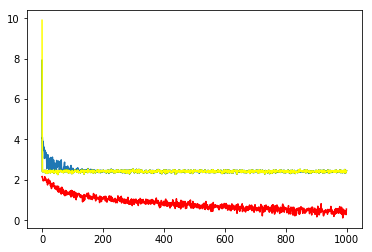

In [22]:
input_size = 8
output_size = 1
hidden_size = 200
    
batch_size = 50
epochs = 1000

#Learning for x**2
learning_rate = 10**-8/100

#Learning for sqrt()
#learning_rate = 2.5*10**-5
#learning_rate = 10**-6

    
Net1 = NN()
Net1.add_layer(input_size, hidden_size,activation=relu)
Net1.add_layer(hidden_size, hidden_size,activation=relu)
Net1.add_layer(hidden_size, output_size, activation=relu)
errors1 = np.zeros(epochs)

Net2 = NN()
Net2.add_layer(input_size, hidden_size,activation=relu)
Net2.add_layer(hidden_size, output_size, activation=relu)
errors2 = np.zeros(epochs)

Net3 = NN()
Net3.add_layer(input_size, hidden_size)#,activation=relu)
Net3.add_layer(hidden_size, hidden_size)#,activation=sigmoid)
Net3.add_layer(hidden_size, hidden_size)#,activation=relu)
Net3.add_layer(hidden_size, output_size, activation=relu)
errors3 = np.zeros(epochs)

Net4 = NN()
Net4.add_layer(input_size, hidden_size,activation=relu)
Net4.add_layer(hidden_size, hidden_size,activation=relu)
Net4.add_layer(hidden_size, hidden_size,activation=relu)
Net4.add_layer(hidden_size, hidden_size,activation=relu)
Net4.add_layer(hidden_size, output_size, activation=relu)
errors4 = np.zeros(epochs)

for i in range(epochs):
    # Generate inputs
    x,x_bit,y=prepare_complex_data(batch_size,lambda x:np.sqrt(x))
    # Forward
    y_hat_1 = Net1.forward(x_bit)
    y_hat_2 = Net2.forward(x_bit)
    y_hat_3 = Net3.forward(x_bit)
    y_hat_4 = Net4.forward(x_bit)
    #Error
    e1 = (y-y_hat_1)
    e2 = (y-y_hat_2)
    e3 = (y-y_hat_3)
    e4 = (y-y_hat_4)
    errors1[i] = np.sqrt(np.sum(e1**2)/batch_size)
    errors2[i] = np.sqrt(np.sum(e2**2)/batch_size)
    errors3[i] = np.sqrt(np.sum(e3**2)/batch_size)
    errors4[i] = np.sqrt(np.sum(e4**2)/batch_size)
    #backward
    Net1.backward(e1, y_hat_1)
    Net2.backward(e2, y_hat_2)
    Net3.backward(e3, y_hat_3)
    Net4.backward(e4, y_hat_4)
    Net1.update_weights(learning_rate*1000)
    Net2.update_weights(learning_rate*100000)
    Net3.update_weights(learning_rate*50)
    Net4.update_weights(learning_rate)

plt.plot(np.log(errors1))
plt.plot(np.log(errors2),color='red')
plt.plot(np.log(errors3),color='green')
plt.plot(np.log(errors4),color='yellow')
plt.show()

## TEST 3: Polynomial layers

In [65]:
input_size = 8
output_size = 1
hidden_size = 20
    
batch_size = 10
epochs = 4000

#Learning for x**2
learning_rate = 10**-10

#Learning for sqrt()
#learning_rate = 2.5*10**-5
#learning_rate = 10**-6

    
Net1 = NN()
Net1.add_polynomial_layer(input_size, hidden_size,activation=relu)
Net1.add_polynomial_layer(hidden_size, output_size, activation=relu)
errors1 = np.zeros(epochs)

Net2 = NN()
Net2.add_layer(input_size, hidden_size,activation=relu)
Net2.add_layer(hidden_size, output_size, activation=relu)
errors2 = np.zeros(epochs)

for i in range(epochs):
    # Generate inputs
    x,x_bit,y=prepare_complex_data(batch_size,lambda x:x**2)
    # Forward
    y_hat_1 = Net1.forward(x_bit)
    y_hat_2 = Net2.forward(x_bit)
    #Error
    e1 = (y-y_hat_1)
    e2 = (y-y_hat_2)
    errors1[i] = np.sqrt(np.sum(e1**2)/batch_size)
    errors2[i] = np.sqrt(np.sum(e2**2)/batch_size)
    #backward
    Net1.backward(e1, y_hat_1)
    Net2.backward(e2, y_hat_2)
    Net1.update_weights(learning_rate*1000)
    Net2.update_weights(learning_rate*1000)

plt.plot(np.log(errors1))
plt.plot(np.log(errors2),color='red')
plt.show()

ValueError: shapes (10,40) and (20,17) not aligned: 40 (dim 1) != 20 (dim 0)

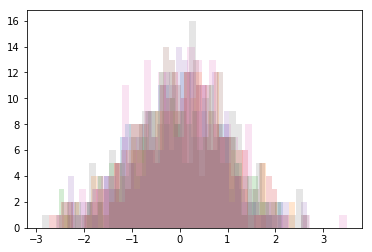

In [10]:
for i in range(8):
    plt.hist(Net4.layers[0].W[:,i],alpha=0.2,bins=40)

(array([1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 6.000e+00, 5.000e+00, 1.600e+01,
        1.300e+01, 2.600e+01, 2.000e+01, 2.700e+01, 3.500e+01, 3.600e+01,
        4.700e+01, 6.800e+01, 9.200e+01, 8.800e+01, 1.230e+02, 1.540e+02,
        1.780e+02, 1.780e+02, 2.500e+02, 2.830e+02, 2.830e+02, 3.460e+02,
        4.080e+02, 4.330e+02, 5.000e+02, 5.620e+02, 6.200e+02, 6.900e+02,
        7.300e+02, 8.050e+02, 9.080e+02, 9.610e+02, 9.370e+02, 1.081e+03,
        1.121e+03, 1.195e+03, 1.190e+03, 1.240e+03, 1.295e+03, 1.315e+03,
        1.284e+03, 1.352e+03, 1.277e+03, 1.245e+03, 1.272e+03, 1.195e+03,
        1.226e+03, 1.124e+03, 1.071e+03, 1.066e+03, 1.003e+03, 9.430e+02,
        8.960e+02, 7.560e+02, 7.610e+02, 6.910e+02, 6.040e+02, 5.700e+02,
        4.720e+02, 4.360e+02, 4.060e+02, 3.650e+02, 2.970e+02, 2.230e+02,
        2.330e+02, 2.010e+02, 1.870e+02, 1.490e+02, 1.250e+02, 1.080e+02,
        7.100e+01, 5.900e+01, 7.100e+0

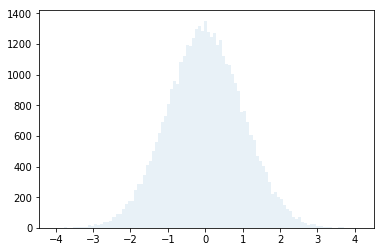

In [11]:
plt.hist(np.reshape(Net4.layers[1].W,-1),alpha=0.1,bins=100)

(array([  1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,   2.,   1.,
          2.,   0.,   0.,   1.,   2.,   0.,   1.,   1.,   2.,   2.,   3.,
          2.,   7.,   3.,   3.,   4.,   5.,   6.,   6.,   8.,  16.,  21.,
         20.,  10.,  24.,  25.,  31.,  24.,  41.,  37.,  35.,  39.,  67.,
         51.,  62.,  82.,  73.,  71., 112., 118., 110., 117., 141., 148.,
        131., 160., 193., 222., 213., 269., 295., 281., 274., 346., 357.,
        360., 335., 348., 404., 433., 443., 443., 484., 463., 523., 539.,
        564., 560., 569., 605., 623., 645., 664., 679., 664., 708., 709.,
        758., 756., 725., 747., 764., 738., 764., 757., 680., 765., 740.,
        720., 725., 724., 677., 664., 656., 669., 649., 580., 554., 565.,
        539., 512., 492., 467., 463., 419., 406., 393., 359., 372., 346.,
        316., 292., 264., 257., 250., 259., 214., 191., 168., 196., 153.,
        151., 160., 102., 106., 109.,  91.,  83.,  62.,  70.,  49.,  43.,
         45.,  46.,  31.,  35.,  23., 

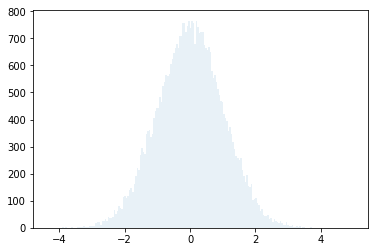

In [12]:
plt.hist(np.reshape(Net4.layers[2].W,-1),alpha=0.1,bins=200)

## Test 2

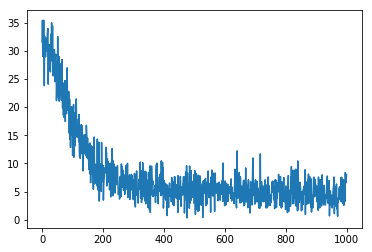

In [76]:
if run_training == True:
    input_size = 3
    output_size = 1
    hidden_size = 5
    
    batch_size = 25
    epochs = 1000
    learning_rate = 10**-3
    
    s = 2
    
    Net = NN()
    Net.add_layer(input_size, hidden_size)
    #Net.add_layer(hidden_size, hidden_size)
    Net.add_layer(hidden_size, output_size,activation=sigmoid)
    errors = np.zeros(epochs)
    
    for i in range(epochs):
        # Generate inputs
        x,y=prepare_data(input_size,batch_size,sigma=s)
        # Forward
        y_hat = Net.forward(x)
        #Error
        e = (y-y_hat)
        errors[i] = np.sum(e**2)
        #backward
        Net.backward(e, y_hat)
        Net.update_weights(learning_rate)
    plt.plot(errors)
    plt.show()

In [65]:
fig = plt.figure()
ax = plt.axes(projection='3d')
N_test = 50
x,y =  prepare_data(3,N_test,sigma=1)
y_hat = Net.forward(x)
y_hat = (y_hat+0.5).astype(int)
#for i in range(N_test*2):
#    print("real {} and pred {}".format(y[i][0],y_hat[i][0]))

x_true=x[y[:,0]-y_hat[:,0]==0]
x_false=x[y[:,0]-y_hat[:,0]!=0]
y_true=y[y==y_hat]
y_false=y[y!=y_hat]
ax.scatter3D(x_true[:,0],x_true[:,1],x_true[:,2], cmap='Greens');
ax.scatter3D(x_false[:,0],x_false[:,1],x_false[:,2], cmap='Reds');

ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>

[5, 6, 89]
